## Supplementary Materials 4: Simulation

This notebook provides the details of the simulation study discussed in Section 3.2 of the journal article associated with this Supplementary Material, "Incremental parsing in a continuous dynamical system: Sentence processing in Gradient Symbolic Computation".

In [1]:
%matplotlib inline

# This notebook uses package 'tqdm' (https://pypi.python.org/pypi/tqdm) to display a progress bar. 
# The package is not installed on SageMathCloud and we uploaded the package on the server. 
# If you run this notebook on your local machine, please install the package, following the instruction in the package website.
import sys
sys.path.insert(0, 'tqdm')
from tqdm import tqdm, tqdm_notebook

import gsc
import numpy as np
import itertools
import h5py
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')     # plotting style

# import brewer2mpl
# curr_palette = brewer2mpl.get_map('Dark2', 'Qualitative', 4).mpl_colors
curr_palette = [
    (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
    (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
    (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
    (0.9058823529411765, 0.1607843137254902, 0.5411764705882353)]

### Language

To make the core computational problems clear, we consider a formal language L = {S1='A B', S2='A C', S3='D B', S4='D C'}. We characterize L by a phrase structure grammar G and convert it to an equivalent set of harmonic grammar rules (see Part 1) as follows. 

In [2]:
G = 'S -> A B | A C | D B | D C'
hg = gsc.HarmonicGrammar(cfg=G, size=2, role_type='span_role', unary_base='filler')

We specify a set of input sentences as follows. Note that each sentence is a sequence of two terminal bindings. By a terminal binding, we mean a binding of a terminal symbol (filler) with a terminal role (span role $\texttt{(i,i+1)}$). It is assumed that the positoinal information is available from the linear order of the input string.

In [3]:
# Specify a list of test sentences (lists of f/r bindings)
test_sentences = [
    ['A/(0,1)', 'B/(1,2)'],   # S1 = 'A B'
    ['A/(0,1)', 'C/(1,2)'],   # S2 = 'A C'
    ['D/(0,1)', 'B/(1,2)'],   # S3 = 'D B'
    ['D/(0,1)', 'C/(1,2)']    # S4 = 'D C'
]

For each input sentence, we specify a target structure as follows. For now, users must provide the information. In a future version, the software will be able to generate a set of grammatical sentences and their corresponding structures. 

In [4]:
# Specify a list of target structures (lists of f/r bindings).
target_bindings = [
    ['A/(0,1)', 'B/(1,2)', 'S[1]/(0,1,2)', 'S/(0,2)'],  # T1 = [S [S[1] [A B]]]
    ['A/(0,1)', 'C/(1,2)', 'S[2]/(0,1,2)', 'S/(0,2)'],  # T2 = [S [S[2] [A C]]]
    ['D/(0,1)', 'B/(1,2)', 'S[3]/(0,1,2)', 'S/(0,2)'],  # T3 = [S [S[3] [D B]]]
    ['D/(0,1)', 'C/(1,2)', 'S[4]/(0,1,2)', 'S/(0,2)']   # T4 = [S [S[4] [D C]]]
]

The GSC model will build a discrete symbolic structure, which can be grammatical or ungrammatical, after processing a sentence. We classify each chosen structure into 5 classes: target (e.g., T1 for input S1), garden path error (e.g., T2 for input S1), local coherence error (e.g., T3 for input S1), other grammatical (e.g., T4 for input S1), and other ungrammatical (any structure other than T1, T2, T3, T4). For that purpose, we define a map from a pair (input_sentence, structure_chosen) to response_class as follows.

In [5]:
# Define a map from (input sentence, structure chosen) to response class resp_class[row][column] 
# Response classes:
#  0: target    
#  1: garden path
#  2: local coherence
#  3: other grammatical
#  4: other ungrammatical
resp_class = [
#   (chosen structure)
#   T1 T2 T3 T4 Ungram  (input sentence)
    [0, 1, 2, 3, 4],    # S1 
    [1, 0, 3, 2, 4],    # S2
    [2, 3, 0, 1, 4],    # S3
    [3, 2, 1, 0, 4]     # S4
]

For example, if the model has built T1 (first column of the matrix $\tt{resp\_class}$) for input S2 (second row), classify the response as 1 (= $\tt{resp\_class}$[second row][first column]), indicating a garden path error. The final column indicates that the model has built an ungrammatical structure. 

### Quantization (commitment) policies

In [6]:
# Users can given the model a quantization policy (t, q(t)) as follows:
# A q policy must be a 2D NumPy array: np.array([[time1, qval(time1)], [time2, qval(time2)], ..., [time_k, qval(time_k)]])
# The first column contains time points and the second column contains q values at those time points.
# q values at other time points will be set by "linear interpolation."
# In this study, we consider three quantization policies, which are specified as list of list of list.
dur = 5.    # word duration
q_policies = np.array(
    [[[0., 0.], [dur,   5.], [2 * dur, 200.]],   # policy 1
     [[0., 0.], [dur,  25.], [2 * dur, 200.]],   # policy 2
     [[0., 0.], [dur, 100.], [2 * dur, 200.]]]   # policy 3 
)

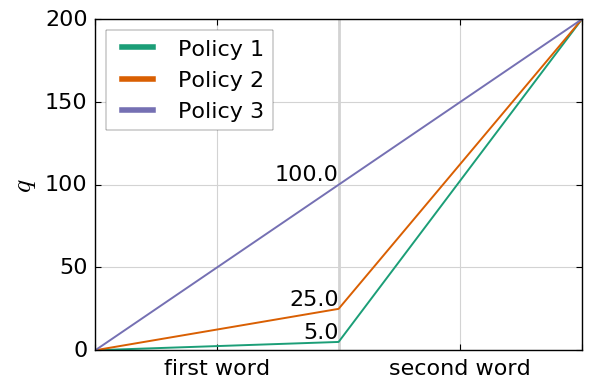

In [7]:
## Plot quantization policies (Figure 3 in the main article)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot([dur, dur], [0., 200.], linestyle='-', c='lightgray', lw=2)

for ii, q_policy in enumerate(q_policies):
    curr_label = 'Policy %d' % (ii + 1)
    ax.plot(q_policy[:,0], q_policy[:,1], color=curr_palette[ii], label=curr_label)
    ax.text(dur, q_policy[1, 1], str(q_policy[1, 1]), fontsize=16, 
            verticalalignment='bottom', horizontalalignment='right')
    
leg = ax.legend(fontsize=16, loc=2)
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

ax.set_xticks(np.linspace(0, 10, 5))
ax.set_xticklabels(['', 'first word', '', 'second word', ''], fontsize=16)
ax.set_ylabel('$q$', fontsize=20)
ax.set_yticks(np.linspace(0, 200, 5))
ax.set_yticklabels(np.linspace(0, 200, 5, dtype=int), fontsize=16)
ax.grid()
ax.set_axisbelow(True)
ax.xaxis.grid(color='lightgray', linestyle='solid')
ax.yaxis.grid(color='lightgray', linestyle='solid')
fig.tight_layout()

# fig.savefig('sim_result_03.pdf', format='pdf', dpi=1200)
# fig.savefig('sim_result_03.png', format='png', dpi=150)

In Section 2.5 of the main article, we argued the model can parse a sentence by increasing quantization strength (or commitment level) $q$ appropriately. To investigate the effect of quantization policy, we consider three different quantization policies. The $q$ value after processing the first word is manipulated in three levels (5, 25, 100). The $q$ values before and after processing a sentence are fixed to 0 and 200, respectively.

### Simulation setting

In incremental processing, computational temperature $T$ is fixed to a small value. The effect of $T$ in incremental processing needs further investigation.

In [8]:
# Simulation setting ==================================================
sim_opts = {
    'dur': dur,                          # word length in time, not in timesteps
    'estr': 1.,                          # external input strength
    'T': 1e-2,                           # computational temperature (update noise magnitude)
    'init_noise_mag': 0.02,              # noise magnitude in the initial state
    'sent_len': 2,                       # sentence length (max. num. of words in a sentence)
    'n_nets': 10,                        # Number of model instances. Each instance has different neural encodings of fillers & roles (and hence bindings)
    'n_trials': 10,                      # Number of trials per sentence type (randomness in dynamics => different possible outcomes across trials for a single model)
    'seed_net0': 10,                     # seed number for model instance. Each model instance will be given a seed number: seed_net0 + net_id
    'seed_trial0': 100,                  # seed number for trial: seed_trial0 + trial_num, where trial_num is the row number of cond_list
    'q_policies': q_policies,            # quantization policies
    'test_sentences': test_sentences,    # input sentences
    'target_bindings': target_bindings,  # target structures of the input sentences
    'resp_class': resp_class,            # map from a chosen structure to one of 5 response classes
    'G': G,                              # context-free grammar (string)
}

# cond_list: trial-level condition information: net_id, cond_id (i.e., policy_id), sentence_id, trial_id 
sim_opts['cond_list'] = list(itertools.product(
        range(sim_opts['n_nets']), range(len(q_policies)), range(len(test_sentences)), range(sim_opts['n_trials'])))

# Depending on the time step constant ('dt'), the activate state trace data can be very big. 
# Users may want to downsample the activation trace to reduce the size of data.
# Sampling points: the (estimated) activation states at these time points will be stored in data. 
# The current setting will create a sequence of time points: [0, 0.05, 0.1, ..., 0.95, 1.0]
# t_samples: activation states at these time points will be stored in data
delta_t = 0.05    # time difference between two time samples 
sim_opts['t_samples'] = np.linspace(0, dur * 2, dur * 2 / delta_t)

# GscNet setting  ==========================================================
gsc_opts = {
#    'dt': 0.01,                 # time-step size (default = 0.001) (not used anymore)
    'T_decay_rate': 0,          # decay rate of temperature (0: do not change temperature)
    'T_init': sim_opts['T'],    # initial value of T
    'T_min': sim_opts['T'],     # minimal value of T
}

### Create a data file and store simulation and model setting

Before running simulations, we create a data file named $\texttt{run1.hdf5}$ and store simulation and model setting parameters. When running simulation, the program will read the information to construct model instances and simulation environments. **NOTE**: if $\texttt{run1.hdf5}$ exists, it will be overwritten and all information contained in the file will be lost. 

In the following, the program will 1,200 trials of simulations. It may take long. For your convenience, we uploaded file $\texttt{run0.hdf5}$ containing all simulation data (please do not overwrite this file). If you do not want to run simulations by yourself, you can jump to section **Distributions of chosen structures** to check the simulation results. 

In [9]:
filename = 'run1.hdf5'     # savefilename, Hierarchical Data Format (https://support.hdfgroup.org/HDF5/) will be used.

string_dt = h5py.special_dtype(vlen=str)
f = h5py.File(filename, 'w')   # Open file for writing. If file exsits, overwrite it. 

# Create a group (node) named "sim_opts" and store sim_opts information (constant across all trials)
group1 = f.create_group("sim_opts")
for key in sim_opts:
    if key in ['test_sentences', 'target_bindings', 'G']:
        group1.create_dataset(name=key, data=np.array(sim_opts[key], dtype=object), dtype=string_dt)
    else:
        group1.create_dataset(name=key, data=np.array(sim_opts[key]))

# Create a group (node) named "gsc_opts" and store gsc_opts information (constant across all trials)
group2 = f.create_group("gsc_opts")
for key in gsc_opts:
    group2.create_dataset(name=key, data=np.array(gsc_opts[key]))

# Create a group (node) named "data" under which trial-level data (one dataset per trial) will be stored
f.create_group('data')
f.flush()
f.close()  # Close file.

# HDF format can store data in a structured format (like a tree). 
# file structure will look like this.
# /           ( <-- root node )
# /sim_opts   ( <- at this node, sim_opts information are stored)
#  dur: 5.
#  estr: 1.
#    :
# /gsc_opts   ( <- at this node, gsc_opts parameters are stored)
#  dt: 0.01
#    :
# /data       ( <- at this node, trial data will be stored )

In [10]:
# Define a function to run simulation conveniently
def run(filename):
    
    f = h5py.File(filename, 'a')    # open file
    
    # Read simulation and model setting
    sim_opts = {}
    for dset_name in f['/sim_opts']:
        sim_opts[dset_name] = f['/sim_opts'][dset_name][...]
        
    gsc_opts = {}
    for dset_name in f['/gsc_opts']:
        gsc_opts[dset_name] = f['/gsc_opts'][dset_name][...]
    
    data = f['/data']

    G = str(sim_opts['G'])
    hg = gsc.HarmonicGrammar(cfg=G, size=2, role_type='span_role', unary_base='filler')
    
    # Check data in the file.
    trial_id_old = [int(name) for name in data]
    if len(trial_id_old) > 0:
        trial_id_curr = np.setdiff1d(np.arange(len(sim_opts['cond_list'])), np.array(trial_id_old))
        if len(trial_id_curr) == 0:
            print('No more trials to run!')
            return None
    else:
        trial_id_curr = np.arange(len(sim_opts['cond_list']))
    
    for trial_num in tqdm_notebook(trial_id_curr):   # widget version
    # for trial_num in tqdm(trial_id_curr):          # text version
        
        try:
            net_id, cond_id, sent_id, trial_id = sim_opts['cond_list'][trial_num]
            
            seed_net   = sim_opts['seed_net0'] + net_id        # seed for model instance
            seed_trial = sim_opts['seed_trial0'] + trial_num   # seed for trial run
            sent = sim_opts['test_sentences'][sent_id]         # input sentence

            # Construct an instance of the GSC model implementing G
            # Different instances of the model will have different distributed representations 
            # of fillers and roles.
            net = gsc.GscNet(hg=hg, opts=gsc_opts, seed=seed_net)            
            net.set_seed(seed_trial)

            # Find a global optimum when q = 0
            # For this purpose, we will fix T to 0 and q to 0 temporarily. 
            net.opts['q_rate'] = 0.
            net.opts['T_init'] = 0.
            net.opts['T_min'] = 0.
            
            net.reset()      # the activation state is set to a random vector.
            net.run(1)       # run the model for a certain amount of time (= 1) with no input. 
            mu = net.actC    # store the end state (approximation of the global optimum) to mu. 
                             # We will set the initial state of the system to mu plus small gaussian noise.

            # Note: where the system starts does not really matter unless q increases really quickly.
            # When q is low, the harmony surface has a single optimum to which the system moves. 
            # So the effect of noise to the initial state will quickly disappear.

            # Reset temperature
            net.opts['T_init'] = sim_opts['T']
            net.opts['T_min']  = sim_opts['T']
            
            # Set quantization policy
            net.opts['q_policy'] = sim_opts['q_policies'][cond_id]

            # reset the model; 
            # the activation state is set to a random vector; 
            # q is set to q_init (= 0 by default)
            # T is set to T_init (check net.opts['T_init'])
            net.reset()

            # Set the initial state to a particular vector with gaussian noise
            # As we described in the above, the result does not depend on the initial state.
            # You can test it by running the simulation after commenting out the line below.
            net.set_init_state(mu=mu, sd=sim_opts['init_noise_mag'])

            # Store the intial state in conceptual coordinates
            # Note that the actC attribute contains the current activation state in conceptual coordinates
            # while the act attribute contains the state in neural coordinates.
            actC_three = []
            actC_three.append(net.actC)

            for word_id, word in enumerate(sent):                    
                # For each word,

                net.clear_input()                       # Remove curr external input if exists
                net.set_input(word, sim_opts['estr'])   # new external input
                net.run(sim_opts['dur'])                # Run 
                actC_three.append(net.actC)             # Store the activation state in conceptual coordinates

            # Check the chosen structure
            # The read_grid_point method will choose a binding with the maximal activation value 
            # in each role as a winner and return a list of winners.
            gp = net.read_grid_point(disp=False)
            
            found = False
            for ii, rp in enumerate(sim_opts['target_bindings']):
                if set(gp) == set(rp):
                    chosen = ii
                    found=True
            if found is False:
                chosen = len(sim_opts['target_bindings'])

            # Get the activation states at a given sequence of time points (t_samples)
            # using linear interpolation.
            q_interp = np.interp(sim_opts['t_samples'], net.traces['t'], net.traces['q'])            
            act_new = np.zeros((len(sim_opts['t_samples']), net.num_units))
            for idx_unit in range(net.num_units):
                act_new[:, idx_unit] = np.interp(sim_opts['t_samples'], net.traces['t'], net.traces['act'][:, idx_unit])

            # Create a data set to store the trial data
            dset = data.create_dataset(name=str(trial_num), data=net.N2C(act_new.T).T, dtype=np.float16)   # smaller            
            dset.attrs['seed_net'] = seed_net
            dset.attrs['seed_trial'] = seed_trial
            dset.attrs['trial_num'] = trial_num
            dset.attrs['net_id'] = net_id
            dset.attrs['cond_id'] = cond_id
            dset.attrs['sent_id'] = sent_id
            dset.attrs['trial_id'] = trial_id
            dset.attrs['actC_three'] = np.array(actC_three)
            # Classify chosen structure given input sentence:
            # 0: target, 1: GP, 2: LC, 3: otherGram, 4: otherUngram
            dset.attrs['response_class'] = sim_opts['resp_class'][sent_id][chosen]

        except KeyboardInterrupt:

            trial_id_old = [int(name) for name in data]
            print("Simulation interrupted! Data has been stored in file '%s'." % filename)
            print("Now the file contains data of %d (of %d) trials." % (len(trial_id_old), len(sim_opts['cond_list'])))
            print("To resume, run this code block again. New data will be appended to the file.")
            break

    f.flush() 
    f.close()

### Running simulation   $[\textit{Note:Executing this cell will take many minutes!}]$

Run the code block below. A progress bar will appear to give you an estimate of running times. You can freely interrupt the program by pressing the stop ('interrupt kernel') button on the menu; or click 'Kernel' on the top down menu and then click 'interrupt'. Software will safely store trial data into file. You can run this block again to resume. In this case, the total number of trials displayed next to the progress bar will decrease by the number of trials you ran before.

In [11]:
# It is assumed that a data file named [filename] containing model and simulation setting parameters 
# exists in the same directory. 
filename = 'run1.hdf5'
run(filename)

### Distributions of chosen structures

In [12]:
filename = 'run0.hdf5'    # If you want to read simulation data that we uploaded, use this filename
# filename = 'run1.hdf5'
f = h5py.File(filename)     # open data file

data = f['/data']
temp = []
for dset_name in data:
    dset = data[dset_name]
    temp.append(dset.attrs['cond_id'])
    
temp = list(set(temp))
temp.sort()
cond_id_all = temp

# resp_dist = np.zeros((5, len(cond_id_all)), dtype=np.int16)
resp_dist = np.zeros((5, 3), dtype=np.int16)
for dset_name in data:
    dset = data[dset_name]
    resp_dist[dset.attrs['response_class'], dset.attrs['cond_id']] += 1
    
f.close()

resp_dist_prop = resp_dist / resp_dist.sum(axis=0)

In [13]:
# Print a table
resp_type = ['Target', 'GardenPath', 'LocalCoherence', 'Other_Gram', 'Other_Ungram']

header = '\t'
for ii in range(len(cond_id_all)):
    header += '\tPolicy%d' % (cond_id_all[ii] + 1)

print(header)
for jj in range(5):
    print(resp_type[jj].rjust(14), end='')
    for ii in range(len(cond_id_all)):
        print('\t%.4f' % resp_dist_prop[jj,cond_id_all[ii]], end='')
    print()
    
n_samples_per_condition = resp_dist.sum(axis=0)
print('N'.rjust(14), end='')
for n_samples in n_samples_per_condition:
    print('\t%d' % n_samples, end='')

		Policy1	Policy2	Policy3
        Target	0.5750	0.9900	0.5525
    GardenPath	0.0050	0.0075	0.4475
LocalCoherence	0.4175	0.0025	0.0000
    Other_Gram	0.0025	0.0000	0.0000
  Other_Ungram	0.0000	0.0000	0.0000
             N	400	400	400

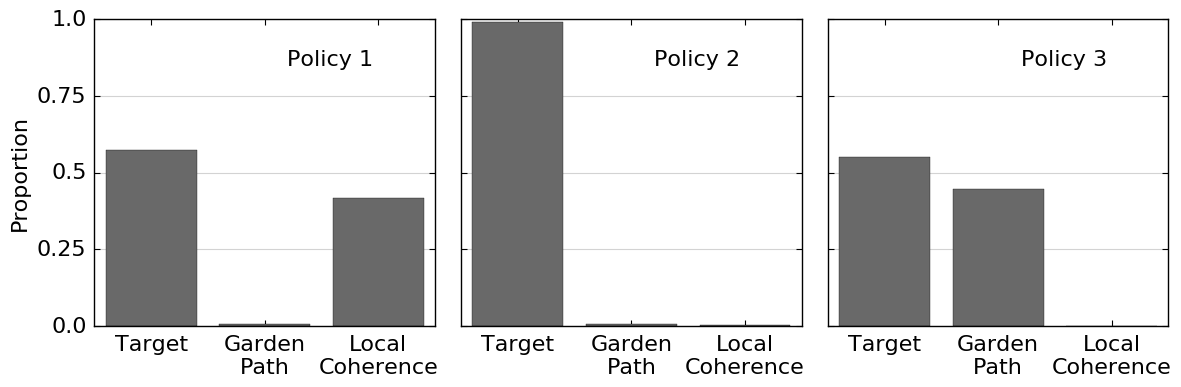

In [14]:
# Plot the distributions (See Figure 4 in the main article)
focus_resp_type = [0, 1, 2]    # We consider the first three conditions (T, GP, LC)
fig, axarr = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
for ii in range(len(axarr)):
    axarr[ii].bar(np.arange(len(focus_resp_type))-0.4,                   
                  resp_dist_prop[:len(focus_resp_type), ii], color='dimgray', alpha=1)

    axarr[ii].text(1.2, 0.85, 'Policy %d'%(ii+1), fontsize=16)
    axarr[ii].set_xticks(np.arange(len(focus_resp_type)))
    axarr[ii].set_xticklabels(['Target', 'Garden\nPath', 'Local\nCoherence'], fontsize=16)
    axarr[ii].set_yticks(np.arange(5)*0.25)
    axarr[ii].set_yticklabels(np.arange(5)*0.25, fontsize=16)
    axarr[ii].set_xlim(-0.5, len(focus_resp_type) - 0.5)
    axarr[ii].set_ylim(0,1)
    if ii == 0:
        axarr[ii].set_ylabel('Proportion', fontsize=16)
    axarr[ii].grid()
    axarr[ii].set_axisbelow(True)
    axarr[ii].xaxis.grid(color='white', linestyle='solid')
    axarr[ii].yaxis.grid(color='lightgray', linestyle='solid')
    
fig.subplots_adjust(wspace=0.08)
fig.tight_layout()
# fig.savefig('sim_result_01.pdf', format='pdf', dpi=1200)
# fig.savefig('sim_result_01.png', format='png', dpi=150)

### Sample activation state trajectories

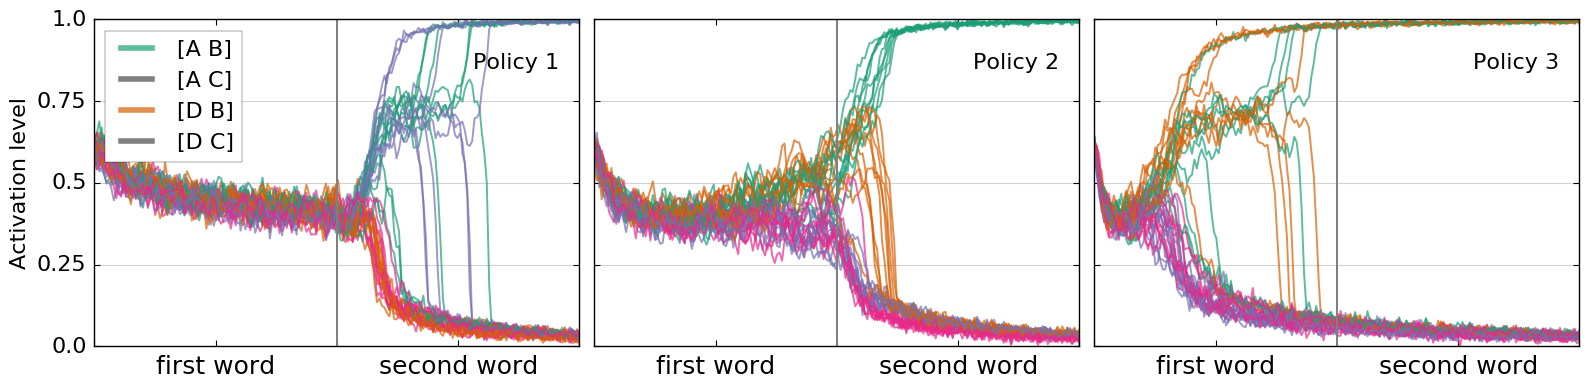

In [15]:
## Plot a subset of sample activation histories. (See Figure 5 in the main article)

f = h5py.File(filename)   # open file

dur = f['/sim_opts']['dur'][...]
data = f['/data']
t_samples = f['/sim_opts']['t_samples'][...]

cond_ids = []
for dset_name in data:
    cond_ids.append(data[dset_name].attrs['cond_id'])
cond_ids = list(set(cond_ids))
cond_ids.sort()

# We will focus on (the activation states of) focus_bindings
# Focus on the full-string bindings:
focus_bindings = ['S[1]/(0,1,2)', 'S[2]/(0,1,2)', 'S[3]/(0,1,2)', 'S[4]/(0,1,2)']

# To select the relevant values, we will use the 'find_bindings' method of 'GscNet' class.
# For this purpose, we construct a model again.
G = str(f['/sim_opts']['G'][...])
hg = gsc.HarmonicGrammar(cfg=G, size=2, role_type='span_role', unary_base='filler')
net = gsc.GscNet(hg=hg)

# Sample act traces: one trial (input S1) per policy per net
fig, axarr = plt.subplots(1, len(cond_ids), sharey=True, figsize=(16, 4))
for dset_name in data:
    dset = data[dset_name]
    cond_id = dset.attrs['cond_id']
    
    if dset.attrs['sent_id'] == 0 and dset.attrs['trial_id'] == 0:
        actC_trace = dset[...]
        
        for idx, binding in enumerate(focus_bindings):
            axarr[cond_id].plot(
                t_samples, actC_trace[:, net.find_bindings(binding)],
                alpha=0.7, c=curr_palette[idx])
            
            axarr[cond_id].plot([dur, dur], [0, 1], linestyle='-', c='gray')
            axarr[cond_id].set_ylim(0,1)
            axarr[cond_id].set_xlim(0,2 * dur)
            axarr[cond_id].set_yticks(np.arange(5) * 0.25)
            axarr[cond_id].set_yticklabels(np.arange(5) * 0.25, fontsize=16)
            axarr[cond_id].grid(True)
            axarr[cond_id].set_axisbelow(True)
            axarr[cond_id].xaxis.grid(False)
            axarr[cond_id].yaxis.grid(color='lightgray', linestyle='solid')
            axarr[cond_id].set_xticks(np.arange(5) * 2.5)
            axarr[cond_id].set_xticklabels(['', 'first word', '', 'second word', ''], fontsize=18)        

for cond_id in cond_ids:
    axarr[cond_id].text(7.8, 0.85, 'Policy %d' % (cond_id + 1), fontsize=16)
    if cond_id == 0:
        axarr[cond_id].set_ylabel('Activation level', fontsize=16)
        leg = axarr[cond_id].legend(
            ['[A B]', '[A C]', '[D B]', '[D C]'], fontsize=16, loc=2)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)

fig.subplots_adjust(wspace=0.08)
fig.tight_layout()

# fig.savefig('sim_result_02.pdf', format='pdf', dpi=1200)
# fig.savefig('sim_result_02.png', format='png', dpi=150)
f.close()

The figure above presents ten (of 100) sample activation histories for input sentence S1. Only the full-string bindings for each output sentence (S[k]/(0,1,2)) are shown and labeled as Sk. 

### Run the model without noise

The response distributions and the sample activation state histories investigated in the above suggest that the model behaves very consistently across trials under Policy 2. In other words, under Policy 2, trial-level activation histories can be described nicely by the expected activation histories. Note that this is not always true. For example, if we average the state histories under Policy 3, we will get a very different profile from the trial-level profiles. 

We investigate the expected activation state change by running the model again, this time without update noise (i.e., $T$ = 0).

In [16]:
# Read simulation (sim_opts) and model setting (gsc_opts) from data file.
f = h5py.File(filename)
sim_opts = {}
for dset_name in f['/sim_opts']:
    sim_opts[dset_name] = f['/sim_opts'][dset_name][...]
G = str(sim_opts['G'])
gsc_opts = {}
for dset_name in f['/gsc_opts']:
    gsc_opts[dset_name] = f['/gsc_opts'][dset_name][...]
f.close()

# To get the expected activation state trajectories, 
# we run the model again with Policy 2 but at this time, T is fixed at 0.
hg = gsc.HarmonicGrammar(cfg=G, size=2, role_type='span_role', unary_base='filler')
net = gsc.GscNet(hg=hg, opts=gsc_opts)

# Find a global optimum when q = 0 (for this purpose, set T to 0 temporarily)
net.opts['q_rate'] = 0.
net.opts['T_init'] = 0.
net.opts['T_min'] = 0.
net.reset()
net.run(1)
mu = net.actC

net.opts['q_policy'] = sim_opts['q_policies'][1]   # Choose Policy 2
sent = sim_opts['test_sentences'][0]               # Choose input sentence S1

actC_three_noise0 = []

net.reset()
net.set_init_state(mu=mu, sd=1e-8)
actC_three_noise0.append(net.actC)     # store act state at time = 0

for word_id, word in enumerate(sent):
    net.clear_input()
    net.set_input(word, sim_opts['estr'])
    net.run(sim_opts['dur'])
    actC_three_noise0.append(net.actC) # store act state after processing word

actC_three_noise0 = np.array(actC_three_noise0)

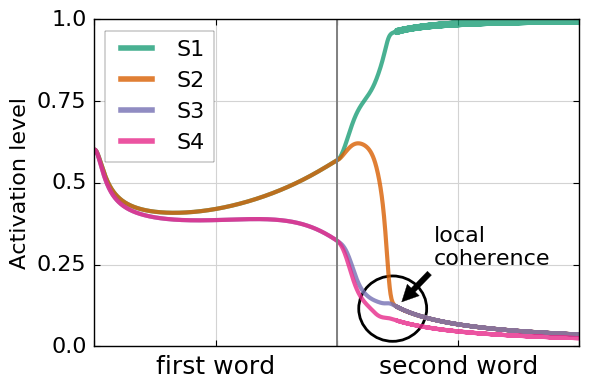

In [17]:
# Plot the activation state change. (Not included in the main article)
from matplotlib.patches import Ellipse     # for annotation

traceC = net.N2C(net.traces['act'].T).T
fig, ax = plt.subplots(figsize=(6,4))
for idx, binding in enumerate(focus_bindings):
    ax.plot(
        net.traces['t'], 
        traceC[:,net.find_bindings(binding)],
        alpha=0.8, lw=3,
        c=curr_palette[idx])
ax.plot([dur,dur], [0,1], linestyle='-', c='gray')
circle1 = Ellipse((6.15, 0.115), width=1.4, height=0.2, color='k', fill=False, lw=2)
ax.add_artist(circle1)
ax.annotate('local\ncoherence', xy=(6.3, 0.13), xytext=(7.0, 0.25),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=16)

ax.set_ylim(0,1)
ax.set_xlim(0,2*dur)
ax.set_yticks(np.arange(5) * 0.25)
ax.set_yticklabels(np.arange(5) * 0.25, fontsize=16)
ax.grid(True)
ax.set_axisbelow(True)
ax.xaxis.grid(color='lightgray', linestyle='solid')
ax.yaxis.grid(color='lightgray', linestyle='solid')
ax.set_xticks(np.arange(5) * 2.5)
ax.set_xticklabels(['', 'first word', '', 'second word', ''], fontsize=18)
ax.set_ylabel('Activation level', fontsize=16)
leg = ax.legend(
    ['S1', 'S2', 'S3', 'S4'], fontsize=16, loc=2)
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

fig.tight_layout()

# fig.savefig('sim_result_02a.svg', format='svg', dpi=1200)
# fig.savefig('sim_result_02a.pdf', format='pdf', dpi=1200)
# fig.savefig('sim_result_02a.png', format='png', dpi=150)

The figure above (not included in the main article) presents the expected activation change in the model following Policy 2. We note that the expected activation value of S[3]/(0,1,2) is higher than the activation of S[4]/(0,1,2) when the model is processing the second word 'B' (see the black circle), although both bindings are inconsistent with context, the first word 'A'. This is because the former is consistent with the bottom-up input while the latter is not. Unlike ideal rational models, the model does not completely suppress the partial activation of locally coherent but globally incoherent structures. Similar phenomena have been observed in visual world paradigm experiments and are interpreted as the local coherence effect (Allopena, Magnuson, & Tanenhaus, 1998; Kukona, Cho, Magnuson, & Tabor, 2014).

The full activation states sampled at three time points ($t$ = 0, 5, 10) are presented below. 

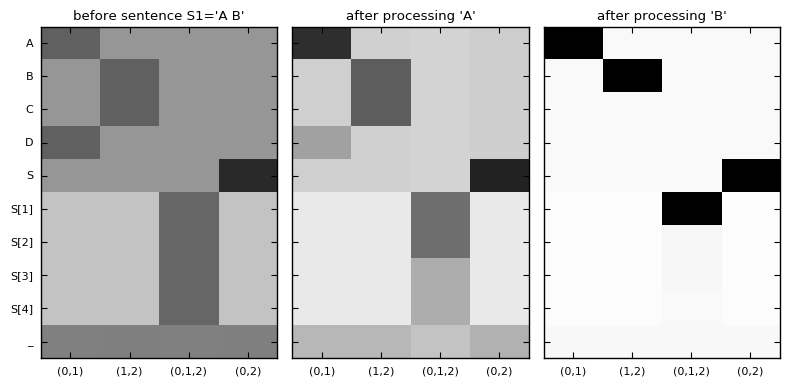

In [18]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(8,4))
plt.sca(axs[0])
net.plot_state(actC=actC_three_noise0[0,:], colorbar=False, disp=False)
plt.grid(False)
plt.title("before sentence S1='A B'")
plt.sca(axs[1])
net.plot_state(actC=actC_three_noise0[1,:], colorbar=False, disp=False)
plt.title("after processing 'A'")
plt.grid(False)
plt.sca(axs[2])
net.plot_state(actC=actC_three_noise0[2,:], colorbar=False, disp=False)
plt.title("after processing 'B'")
plt.grid(False)
fig.tight_layout()

For readability, we presented the activation states in a different format in the main article. Please see below.

In [19]:
# Functions to visualize a full activation state at a given time
def plot_node(ax, net, role_name, actC=None, position=(0,0), print_role_label=True, 
              print_filler_label=False, filler_act_crit=0,
              print_winner=False, filler_crit=0.5):
    
    if actC is None:
        actC = net.actC.copy()
        
    xoffset_role_label = 0.8
    yoffset_filler_label = 1.2
    fontsize_filler = 14
    fontsize_role = 16
    color_square = 'k'  # 'gray'
    color_unit = 'k'  # 'gray'
    alpha = 1
    radius = 0.4
    x, y = position
    idx = net.find_roles(role_name)
    curr_actC = actC[idx]
    height_rect = 3.8
    
    for ii, aa in enumerate(curr_actC):
        if aa >= 0:
            curr_unit = plt.Circle(
                (x + ii, y), radius,
                color=plt.cm.gray(1 - aa),
                alpha=alpha)
            ax.add_artist(curr_unit)
            curr_unit = plt.Circle(
                (x + ii, y), radius, linewidth=1,
                color=color_unit, fill=False)
            ax.add_artist(curr_unit)
        else:
            curr_unit = plt.Circle(
                (x + ii, y), radius,
                color=color_unit, fill=False)
            ax.add_artist(curr_unit)
            curr_unit = plt.Circle(
                (x + ii, y), radius - 0.1,
                color=plt.cm.gray(1 - aa),
                alpha=alpha)
            ax.add_artist(curr_unit)
            curr_unit = plt.Circle(
                (x + ii, y), radius - 0.1,
                color=color_unit, fill=False)
            ax.add_artist(curr_unit)
        
    rect = plt.Rectangle(
        (x - 1, y - 1),   # (x,y)
        len(curr_actC) + 1,          # width
        height_rect,          # height
        color=color_square,
        fill=False, 
        linewidth = 2
    )
    ax.add_artist(rect)
    
    if print_role_label:
        ax.text(x + len(curr_actC) + xoffset_role_label, 
                y + (height_rect - 2) / 2, 
                role_name, 
                fontsize=fontsize_role, 
                color='k',
                horizontalalignment='center', 
                verticalalignment='center', 
                rotation=90)

    for ii in range(net.num_fillers):
        ax.text(x + ii, y + 0.8, net.filler_names[ii], 
                fontsize=fontsize_filler - 2, color='k',
                horizontalalignment='center', 
                verticalalignment='bottom', rotation=90)
        
    xmid = x + (len(curr_actC) - 1) / 2
    ybtm = y - 1
    ytop = ybtm + height_rect
    return (xmid, ytop, ybtm)

def plot_tree(net, actC=None, figsize=(12, 6), axis=(-1,25, -2,13), filler_act_crit=0.5, ax=None):
    
    if actC is None:
        actC = net.actC.copy()
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    (xmid1, ytop1, ybtm1) = plot_node(ax, net, '(0,1)', actC, 
                                      filler_act_crit=filler_act_crit)
    (xmid2, ytop2, ybtm2) = plot_node(ax, net, '(1,2)', actC, (net.num_fillers + 3, 0), 
                                      filler_act_crit=filler_act_crit)
    (xmid3, ytop3, ybtm3) = plot_node(ax, net, '(0,1,2)', actC, (net.num_fillers // 2 + 1.5, 5), 
                                      filler_act_crit=filler_act_crit)
    (xmid4, ytop4, ybtm4) = plot_node(ax, net, '(0,2)', actC, (net.num_fillers // 2 + 1.5, 10), 
                                      filler_act_crit=filler_act_crit, print_filler_label=True)
    ax.plot([xmid1, xmid3], [ytop1, ybtm3], color='k')
    ax.plot([xmid2, xmid3], [ytop2, ybtm3], color='k')
    ax.plot([xmid3, xmid4], [ytop3, ybtm4], color='k')
    ax.axis(axis)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

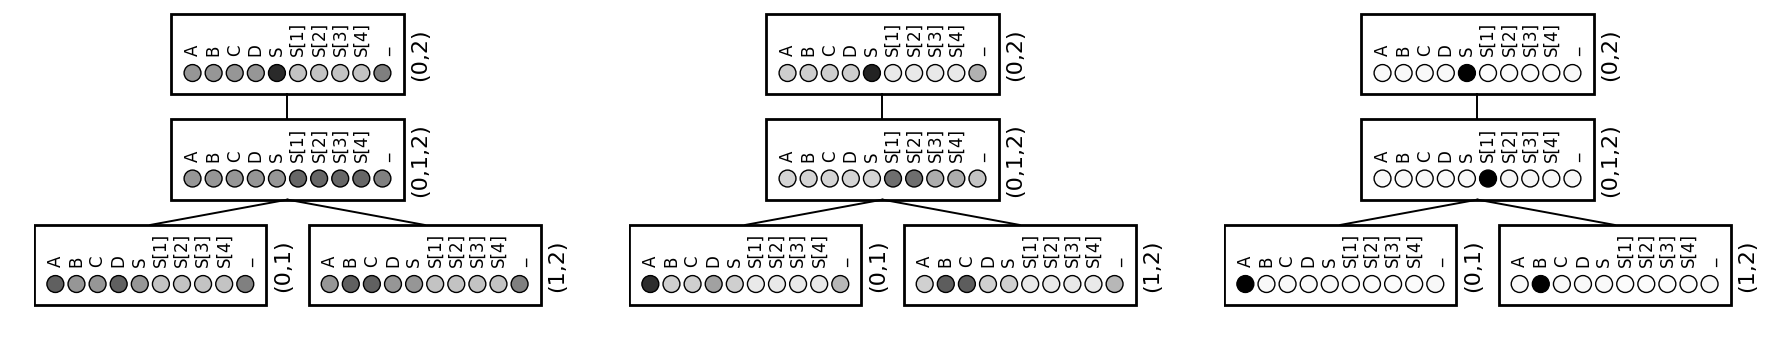

In [20]:
# Figure 6 in the main article
# the activation states at three timepoints, collected from the zero update noise model
fig, axarr = plt.subplots(1, 3, figsize=(18,4))
for ii in range(3):
    plot_tree(net, actC=actC_three_noise0[ii, :], figsize=(6,6), ax=axarr[ii])
fig.tight_layout()

# fig.savefig('sim_result_04c.pdf', format='pdf', dpi=1200)
# fig.savefig('sim_result_04c.png', format='png', dpi=150)

### Stability of the blend states [Not included in the main article]

The GSC model, on average, climbs up a local hump in a harmony surface but the harmony surface changes dynamically as a function of the commitment level $q$. The activation state continues to change until it reaches a discrete symbolic state. What will happen if $q$ stays constant for a certain amount of time? During that period, the harmony surface does not change -- unless external input is updated -- so the model will move to and stay at a peak of a local hump. This suggests the GSC model can move to a blend state mixing multiple interpretations and maintain those interpretations by keeping $q$ constant. 

We show this property rather informally. Let us suppose that the system is at a local optimum $\mathbf{a}^*$, a blend state where total harmony is locally maximal, at a given value of $q$. We will perturb the system by adding small gaussian noise (SD = 0.01) and take this as the state at time 0, $\mathbf{a}(0)$ = $\mathbf{a}^*$ + noise, and let the system update its state with $q$ constant and a $T$ of 0. We will repeat the experiment 20 times. If $\mathbf{a}(t)$ always approaches $\mathbf{a}^*$ (equivalently, $\|\mathbf{a}(t) - \mathbf{a}^*\|$ always approaches 0) as $t \rightarrow \infty$, then $\mathbf{a}^*$ is called an *attractor* or *asymptotically stable equilibrium point* (Strogatz, 1994), suggesting that the system can really hold on to the multiple interpretations implied by a blend state. (Note: If the perturbation noise is too large, then, the system may be displaced to be on a different local hump so will move to another local optimum.)

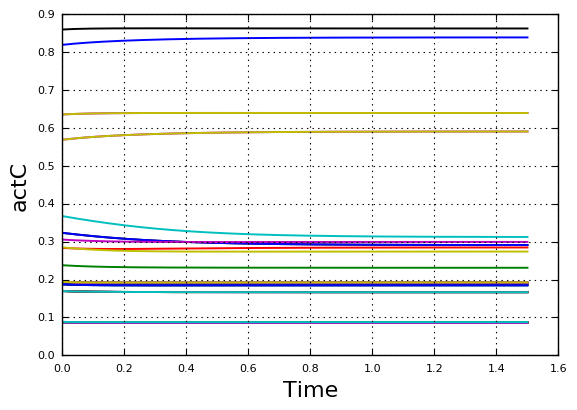

In [21]:
# Choose the blend state after processing the first word of S1 in the model without update noise.
curr_stateC = actC_three_noise0[1, :]

net.opts['q_policy'] = None      # Do not use q-policy. In this setting, the program will use 'q_rate' parameter to change q values
net.opts['q_rate'] = 0           # Set q_rate (dq/dt) to 0. q will not change 
net.opts['q_init'] = 25          # When the reset method is called, q will be reset to q_init stored in the opts.
net.opts['T_init'] = 0
net.opts['T_min'] = 0

# Fix T to 0 and q to 25, the value of q after processing the first word in Policy 2. 
net.reset()
net.act = net.C2N(curr_stateC)   # Set the initial state to the sampled state.
net.set_input('A/(0,1)', 1.)     # Set external input
net.run(1.5)                     # Run the model
net.plot_trace('actC')           # Plot the activation trace to check visually whether the model converged to a state.
stable_blend_state = net.act     # Store the end state. We will test whether it is an attractor.

Now we perturb the system from the candidate stable blend state by adding gaussian noise. Then, we let the model update its state again. As before, $q$ is fixed to the present value and $T$ is set to 0. 

In [22]:
noise_magnitude = 0.1   # the magnitude (SD) of perturbation

num_trials = 20         # Number of trials
test_dur = 5

t_samples = np.linspace(0, 5, 100)
dist_traces = np.zeros((num_trials, len(t_samples)))

for ii in tqdm_notebook(range(num_trials)):
    net.reset()
    net.set_input('A/(0,1)', 1.)   # Set the external input
    
    # Add gaussian noise to the stored blend state to set the initial state.
    net.act = stable_blend_state + noise_magnitude * np.random.randn(net.num_units)
    net.run(test_dur)
    
    # Get activation states at given time points; linear interpolation
    act_trace = np.zeros((len(t_samples), net.num_units))
    for col in range(net.num_units):
        act_trace[:, col] = np.interp(t_samples, net.traces['t'], net.traces['act'][:, col])
    
    actC_trace = net.N2C(act_trace.T).T
    
    # Euclidean distance of the state at time t from the blend state.
    diff = act_trace - np.tile(stable_blend_state, (act_trace.shape[0], 1))
    dist_traces[ii, :] = np.sqrt((diff ** 2).sum(axis=1))

Now we plot the Euclidean distance between $\mathbf{a}(t)$ and $\mathbf{a}^*$ against time $t$.   

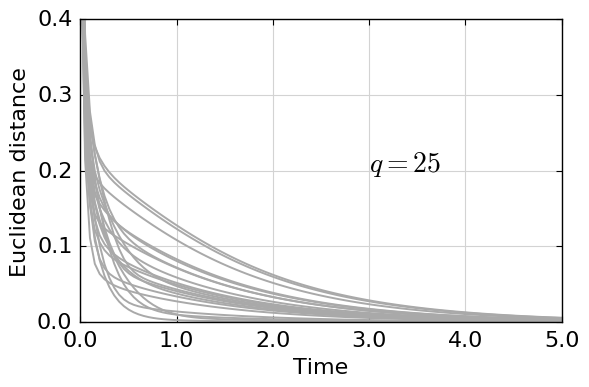

In [23]:
# Plot the Euclidean distance of state a(t) from the blend state a*

f, ax = plt.subplots(figsize=(6, 4))
ax.plot(t_samples, dist_traces.T, c='darkgray')
ax.text(3, 0.2, '$q = 25$', fontsize=20)
ax.grid(True)
ax.set_axisbelow(True)
ax.xaxis.grid(color='lightgray', linestyle='solid')
ax.yaxis.grid(color='lightgray', linestyle='solid')
ax.set_ylabel('Euclidean distance', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.set_xticks(np.linspace(0, 5, 6))
ax.set_xticklabels(np.linspace(0, 5, 6), fontsize=16)
ax.set_yticks(np.linspace(0, 0.4, 5))
ax.set_yticklabels(np.linspace(0, 0.4, 5), fontsize=16)
ax.set_xlim(0, 5)
ax.set_ylim(0, 0.4)
f.tight_layout()
None

# f.savefig('sim_result_05.pdf', format='pdf', dpi=1200)
# f.savefig('sim_result_05.png', format='png', dpi=150)

The figure above suggests that the system has returned to the candidate stable blend state, suggesting that it is really an attractor. The result implies that the GSC model can hold temporary ambiguity as far as it keeps the commitment level constant.

#### References

* Allopenna, Paul D., James S. Magnuson & Michael K. Tanenhaus. 1998. Tracking the time course of spoken word recognition using eye movements: Evidence for continuous mapping models. Journal of Memory and Language 38(4). 419–439. doi:10.1006/jmla.1997.2558.
* Kukona, Anuenue, Pyeong Whan Cho, James S. Magnuson & Whitney Tabor. 2014. Lexical interference effects in sentence processing: Evidence from the visual world paradigm and self-organizing models. Journal of Experimental Psychology: Learning, Memory, and Cognition 40(2). 326–347. doi:10.1037/a0034903.
* Strogatz, Steven H. 1994. Nonlinear dynamics and chaos: With applications to physics, biology, chemistry, and engineering. Westview Press.